# EfficientNetB0V2 with SMOTE for Imbalanced data with final dataset

# Import Libraries

In [1]:
from clearml import Task
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import random
import shutil
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Imbalanced data')

ClearML Task: created new task id=6a36263d972d4370aa6a22b7c29bd170
2024-04-13 12:36:48,461 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/6a36263d972d4370aa6a22b7c29bd170/output/log


# Data Extraction

In [44]:
dataset_path = "D:\\University\\ArchitectureStyles\\archive\\architectural-styles-dataset"
def get_image_paths_and_labels(directory_path):
    data = []
    for root, dirs, files in os.walk(directory_path):
        for label in dirs:
            label_path = os.path.join(root, label)
            for image_path in glob(os.path.join(label_path, "*")):  
                if os.path.isfile(image_path):
                    label_hierarchy = os.path.relpath(label_path, directory_path).split(os.path.sep)
                    label_string = ", ".join(label_hierarchy)
                    data.append((image_path, label_string))

    return data

In [45]:
images_with_labels = get_image_paths_and_labels(dataset_path)
data = pd.DataFrame(images_with_labels, columns=['image_name', 'label'])
data

,image_name,label
0,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Achaemenid architecture\000000.jpg,Achaemenid architecture
1,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Achaemenid architecture\000002.jpg,Achaemenid architecture
2,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Achaemenid architecture\000003.jpg,Achaemenid architecture
3,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Achaemenid architecture\000004.jpg,Achaemenid architecture
4,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Achaemenid architecture\000005.jpg,Achaemenid architecture
...,...,...
9725,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Tudor Revival architecture\969_800px-Klehm_House_4.jpg,Tudor Revival architecture
9726,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Tudor Revival architecture\970_800px-Klehm_House_5.jpg,Tudor Revival architecture
9727,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Tudor Revival architecture\971_800px-Klehm_House_2.jpg,Tudor Revival architecture
9728,D:\University\ArchitectureStyles\archive\architectural-styles-dataset\Tudor Revival architecture\974_800px-United_Brethren_Church_%28Aurora%2C_Nebraska%29_1.JPG,Tudor Revival architecture


# Data Exploration

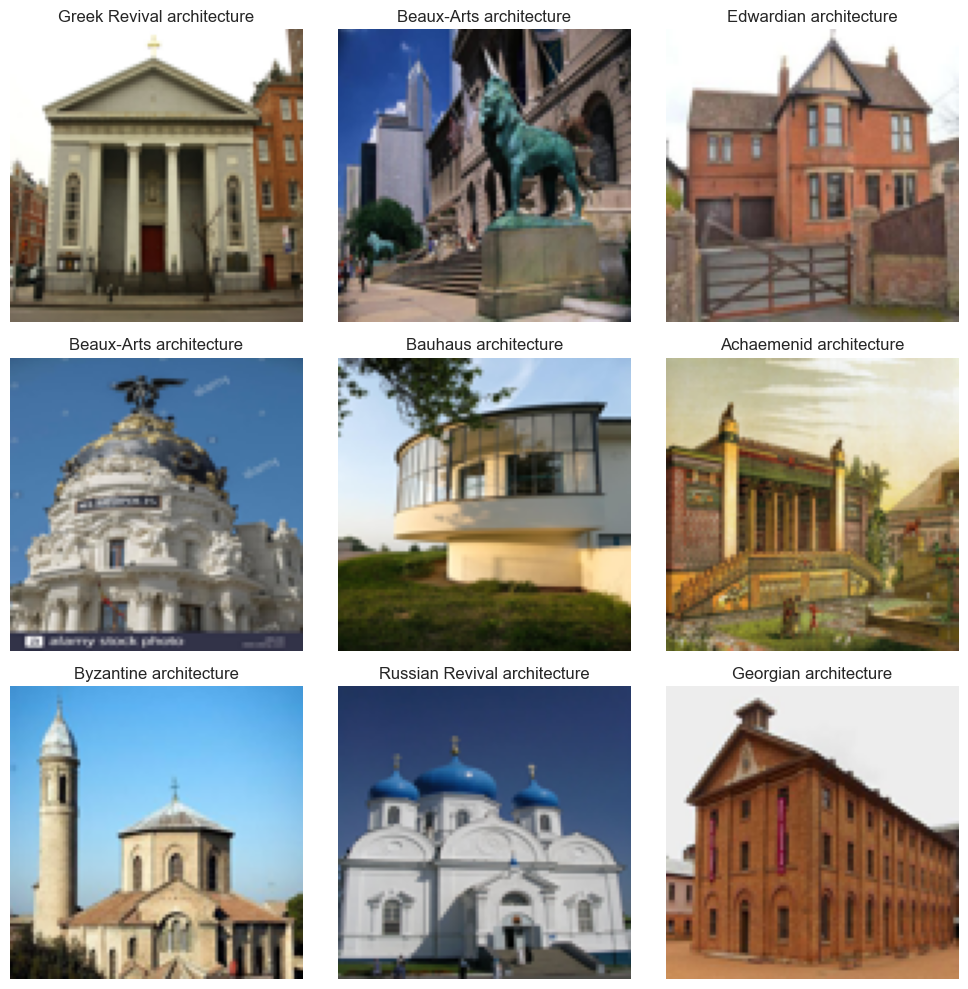

In [46]:
classes = [subfolder for subfolder in os.listdir(dataset_path) if
           os.path.isdir(os.path.join(dataset_path, subfolder))]
plt.figure(figsize=(10, 10))
data_to_show = data.sample(frac=1)[:9]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = Image.open(data_to_show.iloc[i, 0]) 
    img_resized = img.resize((100, 100))
    plt.imshow(img_resized)
    plt.title(data_to_show.iloc[i, 1])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Split

In [47]:
train_dataset, temp_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.2,
                                               random_state=42)
test_dataset, validation_dataset = train_test_split(temp_dataset,
                                                    stratify=temp_dataset['label'],
                                                    test_size=0.5,
                                                    random_state=42)
print(f"Train : Validation : Test - {train_dataset.shape} : {validation_dataset.shape} : {test_dataset.shape}")

Train : Validation : Test - (7784, 2) : (973, 2) : (973, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


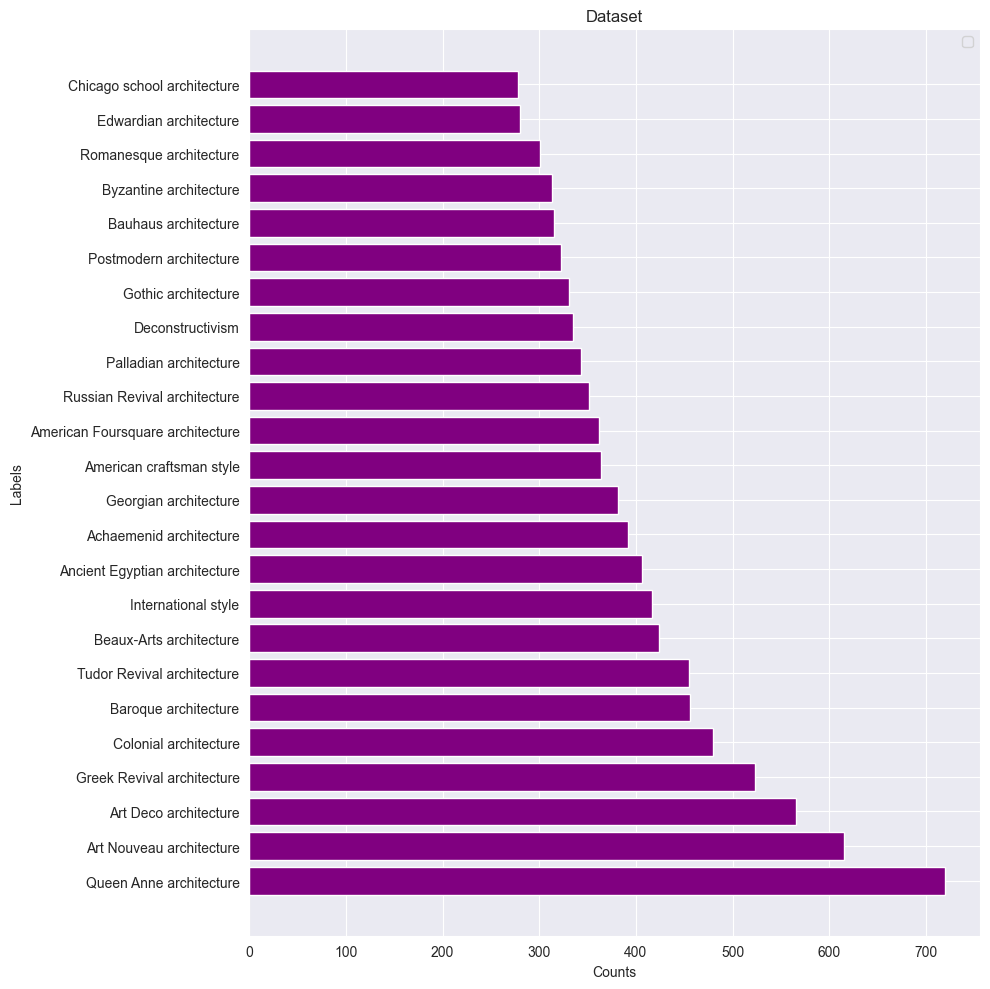

In [48]:
general_dataset_labels = data['label'].value_counts()
unique_labels = general_dataset_labels.index.tolist()
unique_labels.sort(key=lambda label: general_dataset_labels[label], reverse=True)

plt.figure(figsize=(10, 10))
plt.barh(range(len(unique_labels)), [general_dataset_labels.get(label, 0) for label in unique_labels], color='purple')
plt.title('Dataset')

plt.xlabel('Counts')
plt.ylabel('Labels')
plt.yticks(range(len(unique_labels)), unique_labels)
plt.tight_layout()
plt.show()


# Image Data Generators

In [49]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

abs_file_names = []

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.4,1.5],
                                   )

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    num_workers=4,
)

validation_generator = test_datagen.flow_from_dataframe(
    validation_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    num_workers=4,
)
test_generator = test_datagen.flow_from_dataframe(
    test_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    num_workers=4,
)

Found 7784 validated image filenames belonging to 24 classes.
Found 973 validated image filenames belonging to 24 classes.
Found 973 validated image filenames belonging to 24 classes.


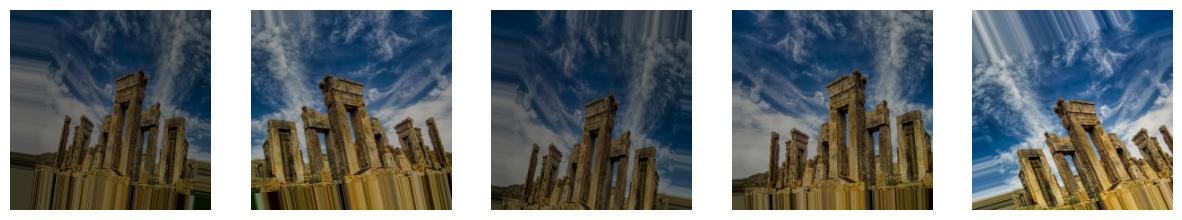

In [50]:
augmented_images = [train_generator[0][0][0] for _ in range(5)]  
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image in enumerate(augmented_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


# Creating Model

In [51]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [52]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [58]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                        include_top=False,
                                                        weights='imagenet')

    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)

    x = base_model(x)
    base_model.trainable = False
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(24, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [59]:
arch_model = arc_model(IMG_SIZE)
# Print a summary for each layer
print(arch_model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,942,952 (34.11 MB)

 Trainable params: 3,023,640 (11.53 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None


In [61]:
arch_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.F1Score, "precision"])
Image.MAX_IMAGE_PIXELS = None

In [63]:
res = arch_model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data = validation_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 210s 846ms/step - accuracy: 0.0692 - f1_score: 0.0073 - loss: 3.1475 - precision: 0.0000e+00 - val_accuracy: 0.0740 - val_f1_score: 0.0057 - val_loss: 3.1461 - val_precision: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 212s 854ms/step - accuracy: 0.0722 - f1_score: 0.0067 - loss: 3.1515 - precision: 0.0000e+00 - val_accuracy: 0.0740 - val_f1_score: 0.0057 - val_loss: 3.1461 - val_precision: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.0749 - f1_score: 0.0065 - loss: 3.1491 - precision: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
244/244 ━━━━━━━━━━━━━━━━━━━━ 209s 844ms/step - accuracy: 0.0749 - f1_score: 0.0065 - loss: 3.1491 - precision: 0.0000e+00 - val_accuracy: 0.0740 - val_f1_score: 0.0057 - val_loss: 3.1461 - val_precision: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 211

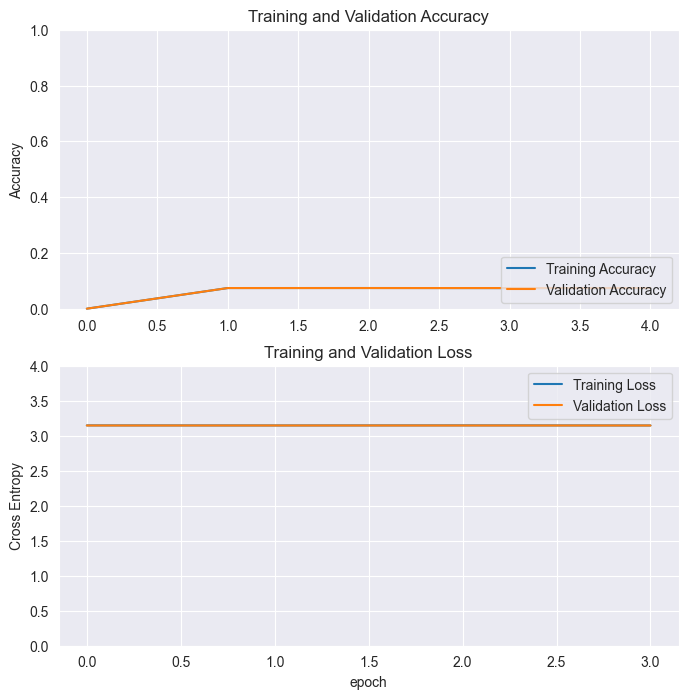

In [64]:
    # validation_steps=20)
acc = [0.] + res.history['accuracy']
val_acc = [0.] + res.history['val_accuracy']

loss = res.history['loss']
val_loss = res.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
loss, accuracy = arch_model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



ValueError: too many values to unpack (expected 2)

In [67]:
prediction = arch_model.predict(test_generator, batch_size=BATCH_SIZE, verbose=0)
pr = np.argmax(prediction, axis=1)
print(classification_report(test_generator.labels, pr, target_names=unique_labels))

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                  precision    recall  f1-score   support

         Queen Anne architecture       0.00      0.00      0.00        40
        Art Nouveau architecture       0.00      0.00      0.00        36
           Art Deco architecture       0.00      0.00      0.00        36
      Greek Revival architecture       0.00      0.00      0.00        41
           Colonial architecture       0.00      0.00      0.00        56
            Baroque architecture       0.00      0.00      0.00        61
      Tudor Revival architecture       0.00      0.00      0.00        46
         Beaux-Arts architecture       0.00      0.00      0.00        31
             International style       0.00      0.00      0.00        42
   Ancient Egyptian architecture       0.00      0.00      0.00        32
         Achaemenid architecture       0.00      0.00      0.00        28
           Georgian architecture       0.00      0.00      0.00        48
        American craftsman style     

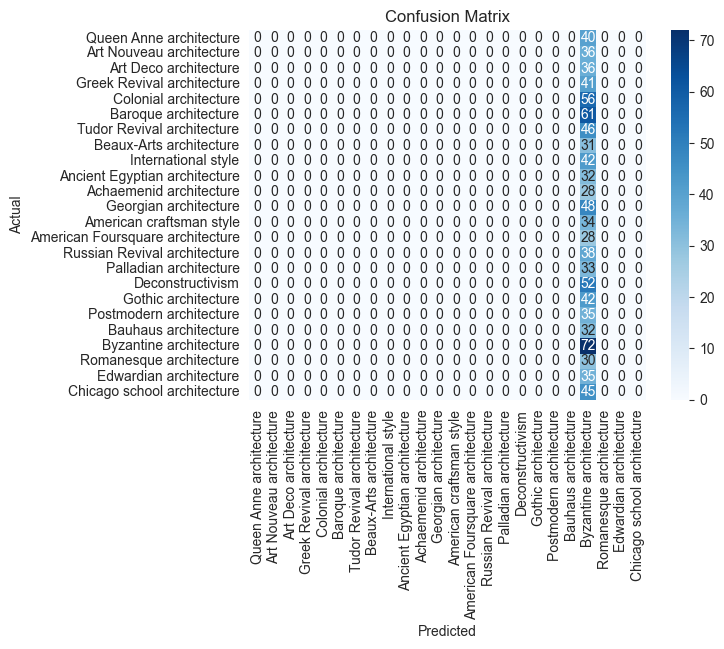

In [68]:
conf_matrix = confusion_matrix(test_generator.labels, pr)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [69]:
for epoch, history in enumerate(res.history['loss']):
    task.get_logger().report_scalar("training", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['accuracy']):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_loss']):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_accuracy']):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)


In [32]:
arch_model.save("imbalanced.h5")
task.upload_artifact("imbalanced.h5", name="imbalanced")

TypeError: F1Score.get_config() missing 1 required positional argument: 'self'